In [1]:
import os
import pickle
import sys
import styling
import matplotlib.pyplot as plt
from datasets import load_from_disk
import numpy as np
import ml_confs
configs = ml_confs.from_file('ordered_MNIST/configs.yaml', register_jax_pytree=False)
ordered_MNIST = load_from_disk('ordered_MNIST/data/')
# Creating a copy of the dataset in numpy format
np_ordered_MNIST = ordered_MNIST.with_format(
    type="numpy", columns=["image", "label"]
)
configs.tabulate()

┏━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃ Key           ┃ Value ┃ Type  ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ classes       │ 5     │ int   │
│ train_samples │ 1001  │ int   │
│ val_ratio     │ 0.2   │ float │
│ test_samples  │ 1001  │ int   │
│ num_rng_seeds │ 20    │ int   │
│ batch_size    │ 128   │ int   │
│ eval_up_to_t  │ 15    │ int   │
│ reduced_rank  │ True  │ bool  │
│ max_epochs    │ 150   │ int   │
│ trial_budget  │ 50    │ int   │
└───────────────┴───────┴───────┘

In [6]:
#List and unpickle all files in "results/"
reports = {}
for file in os.listdir("ordered_MNIST/results/"):
    if file.endswith(".pkl"):
        with open("ordered_MNIST/results/"+file, "rb") as f:
            restored_report = pickle.load(f)
            model_name = restored_report.pop("name")
            reports[model_name] = restored_report

def timing_report(report):
    fit_time = f"${report['fit_time']:0.3f}"
    if 'fit_time_std' in report:
        fit_time += f" \pm {report['fit_time_std']:0.3f}$"
    else:
        fit_time += "$"
    if 'time_per_epoch' in report:
        time_per_epoch = f"${report['time_per_epoch']:0.3f}"
        if 'time_per_epoch_std' in report:
            time_per_epoch += f" \pm {report['time_per_epoch_std']:0.3f}$"
        else:
            time_per_epoch += "$"
    else:
        time_per_epoch = "-"
    return fit_time, time_per_epoch

In [7]:
ordered_models = [
    'DPNets',
    'DPNets-relaxed',
    'Oracle-Features',
    'VAMPNets',
    'DynamicalAE',
    'ConsistentAE',
    'DMD',
    #'KernelDMD-Poly3',
    'KernelDMD-RBF',
    #'KernelDMD-AbsExp'
]

/tmp/ipykernel_3195109/1315672730.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(fluid_flow_results['prediction_steps'], fluid_flow_results[model_name], '-', c='gray', ls = dmd_ls.pop(0))


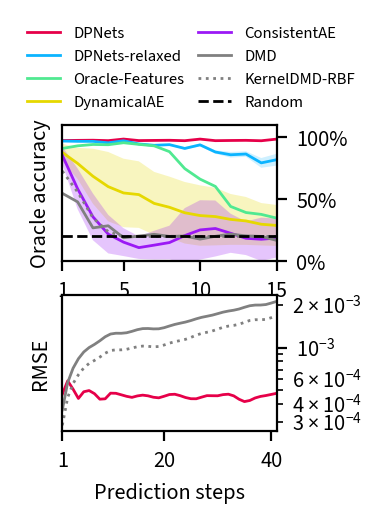

In [56]:
fig, axes = plt.subplots(2, 1, figsize=styling.figsize(0.3, 1/1.5), dpi=200,)
dmd_ls = ['solid', 'dotted', 'dashed', 'dashdot']

# Ordered MNIST
ax = axes[0]
for model_name in ordered_models:
    if model_name in reports:
        report = reports[model_name]
        t = list(range(1, configs.eval_up_to_t + 1))
        acc = np.array(report['accuracy'])
        acc_std = np.array(report.get('accuracy_std', np.zeros_like(acc)))      
        if model_name in ['DPNets', 'DPNets-relaxed']:
            model_name = model_name
            ax.plot(t, acc, '-', lw=1.0, label=model_name)
            ax.fill_between(t, acc - acc_std, acc + acc_std, alpha=0.2)
        elif 'DMD' in model_name: 
            ax.plot(t, acc, color='gray', ls = dmd_ls.pop(0), label=model_name)
            ax.fill_between(t, acc - acc_std, acc + acc_std, alpha=0.25)
        else:
            ax.plot(t, acc, '-', label=model_name)
            ax.fill_between(t, acc - acc_std, acc + acc_std, alpha=0.25)
ax.axhline(1/configs.classes, color='black', linestyle='--', label='Random', lw=1)

ax.legend(frameon=False, loc='lower center', bbox_to_anchor=(0, 1, 1.2, 0), ncol=2, fontsize=6, columnspacing=0.8)
ax.margins(x=0)
ax.set_ylim(0, 1.1)
#Add y ticks for every 20% of accuracy
ax.set_yticks(np.arange(0, 1.1, 0.5))
ax.set_yticklabels([f'{i*100:.0f}%' for i in np.arange(0, 1.1, 0.5)])
ax.set_xticks([1, 5, 10, 15])
ax.set_xlabel('Time steps')
ax.set_ylabel('Oracle accuracy')
ax.yaxis.tick_right()

# Fluid Flow:
dmd_ls = ['solid', 'dotted', 'dashed', 'dashdot']
import pandas as pd
fluid_flow_results = pd.read_csv('fluid_flow_results.csv', sep='\t')

ax=axes[1]

for idx, model_name in enumerate(ordered_models):
    if model_name in fluid_flow_results:
        if 'DMD' in model_name: 
            ax.plot(fluid_flow_results['prediction_steps'], fluid_flow_results[model_name], '-', c='gray', ls = dmd_ls.pop(0))
        else:
            ax.plot(fluid_flow_results['prediction_steps'], fluid_flow_results[model_name], '-', c=styling.color_palette[idx])

ax.set_xmargin(0)
ax.set_ylabel('RMSE')
ax.set_xticks([1, 20, 40])
ax.set_yscale('log')
ax.yaxis.tick_right()
ax.set_xlabel('Prediction steps')

fig.subplots_adjust(
    bottom=0.15,
    top=0.77,
    left=0.1,
    right=0.75,
    hspace=0.25)
# fig.tight_layout()
# fig.savefig('figures/oracle_accuracy.pdf')
fig.savefig('forecast.pdf')


In [7]:
from tabulate import tabulate

In [8]:
headers = [r"\textbf{Model}", r"\textbf{Fit Time (s)}", r"\textbf{Time per Epoch (s)}"]
table_records = []
for report in reports:
    table_records.append(timing_report(report))
print(tabulate(table_records, headers=headers, tablefmt="latex_raw", colalign=("right", "center", "center")))

TypeError: string indices must be integers, not 'str'

## Sample trajectories

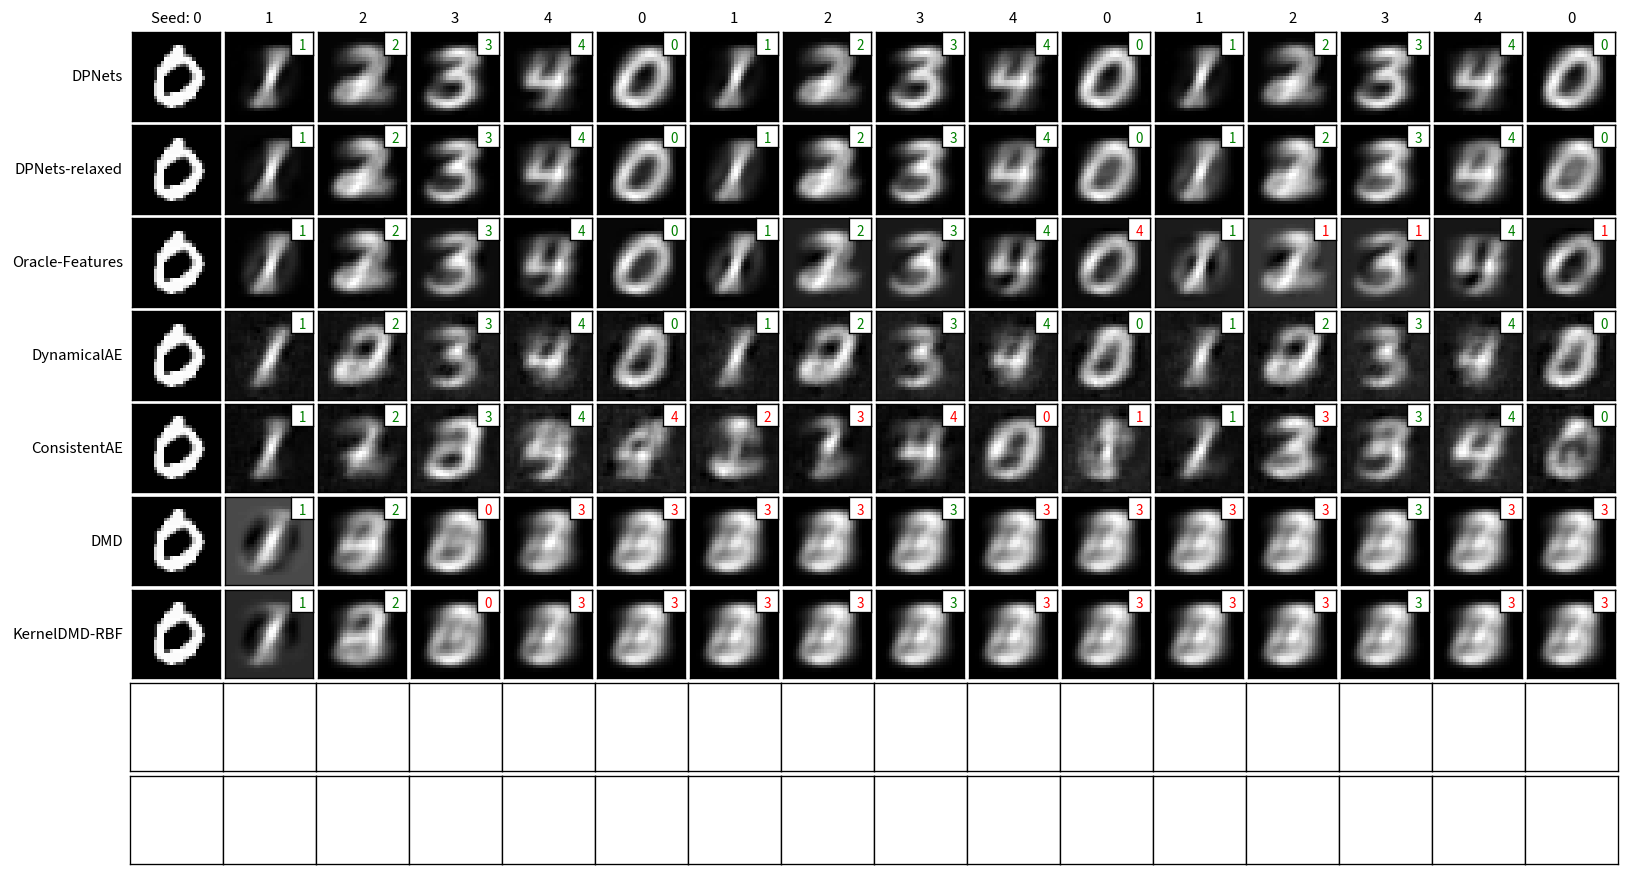

In [9]:
n_models = len(reports)
num_cols = configs.eval_up_to_t + 1
times = list(range(1, num_cols))
fig, axes = plt.subplots(n_models, num_cols, figsize=(num_cols, n_models), sharex=True, sharey=True)

ax_settings = {'xticks': [], 'yticks': [], 'facecolor': 'white'}

test_seed_idx = 0
# Remove margins between columns
plt.subplots_adjust(wspace=0)
row_idx = 0
for model_name in ordered_models:
    if model_name not in reports:
        continue
    ax = axes[row_idx, 0]
    #Display seed 
    ax.imshow(np_ordered_MNIST['test']['image'][test_seed_idx], cmap='gray')
    # Remove axes and ticks
    ax.set(**ax_settings)
    model_eval = reports[model_name]
    for t_idx in range(num_cols - 1):
        pred_label = model_eval['label'][t_idx][test_seed_idx]
        true_label = (np_ordered_MNIST['test']['label'][test_seed_idx] + times[t_idx])%configs.classes
        img = model_eval['image'][t_idx][test_seed_idx]
        # Set subplot for the current class
        ax = axes[row_idx, t_idx + 1]
        # Plot the MNIST image
        ax.imshow(img, cmap='gray')
        # Remove axes and ticks
        ax.set(**ax_settings)
        # Add an inset for the predicted label in the upper right corner
        if pred_label == true_label:
            color = 'green'
        else:
            color = 'red'
        inset_ax = ax.inset_axes([0.75, 0.75, 0.25, 0.25])
        inset_ax.set_xlim(0, 1)
        inset_ax.set_ylim(0, 1)
        inset_ax.text(0.5, 0.4, f"{pred_label}" , color=color, fontsize=9, ha='center', va='center')
        inset_ax.set_xticks([])
        inset_ax.set_yticks([])
        #inset_ax.axis('off')
        inset_ax.set_facecolor('white')
    ax.text(-0.1, 0.5, model_name, fontsize=10, ha='right', va='center', transform=axes[row_idx, 0].transAxes)
    row_idx += 1

for class_idx in range(num_cols):
    title = (np_ordered_MNIST['test']['label'][test_seed_idx] + class_idx)%configs.classes
    if class_idx == 0:
        axes[0, class_idx].set_title(f"Seed: {title}", fontsize=10)
    else:
        axes[0, class_idx].set_title(f"{title}", fontsize=10)
#Remove hspace
plt.subplots_adjust(hspace=0.05)
plt.show()
fig.savefig('figures/qualitative.png')